### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 2
### Due: Friday, Feb 4th at 11.59pm CST
---

## Problem 1

This question is about Monte Carlo integration. A standard Gaussian integral takes the form 

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = 2\sigma^4 .$$

1) Write down the usual form of a Gaussian distribution with $\mu=0$ and $\sigma=\sigma$ that is normalized between $\infty$ and $+\infty$. What is the corresponding form of a half-Gaussian distribution between $0$ and $+\infty$? (Remember that the half-Gaussian distribution must be normalized such that it integrates to one.)

2) Manipulate the above equation such that you can write the left hand side in terms of a normalized half-Gaussian distribution. 

3) Draw $N=10^5$ samples from a $\sigma=3$ normal distribution, mask the samples such that only positive values are accepted, then perform Monte Carlo integration using your equation in (2). Confirm that this *approximately* matches the value computed from the right hand side of the equation. If you don't get approximately matching values then you may have forgotten normalization factors for the Gaussian, or constant factors from translating a normalized Gaussian to a half-Gaussian.

4) Repeat (3) for $N=[10^2,10^3,10^4]$, computing the integral using $100$ different batches of random samples for each $N$. Record all calculated values at all $N$. 

5) Make a plot that shows $\log_{10}N$ along the $x$-axis and the spread between the maximum and minimum Monte Carlo integral values that you get at each $N$ on the $y$-axis. (Note: matplotlib's `fill_between` command is useful for this). Plot a horizontal line on the same figure to show the precise mathematical value. You should see that Monte Carlo integration results in less numerical spread as $N$ gets larger.

### Solution

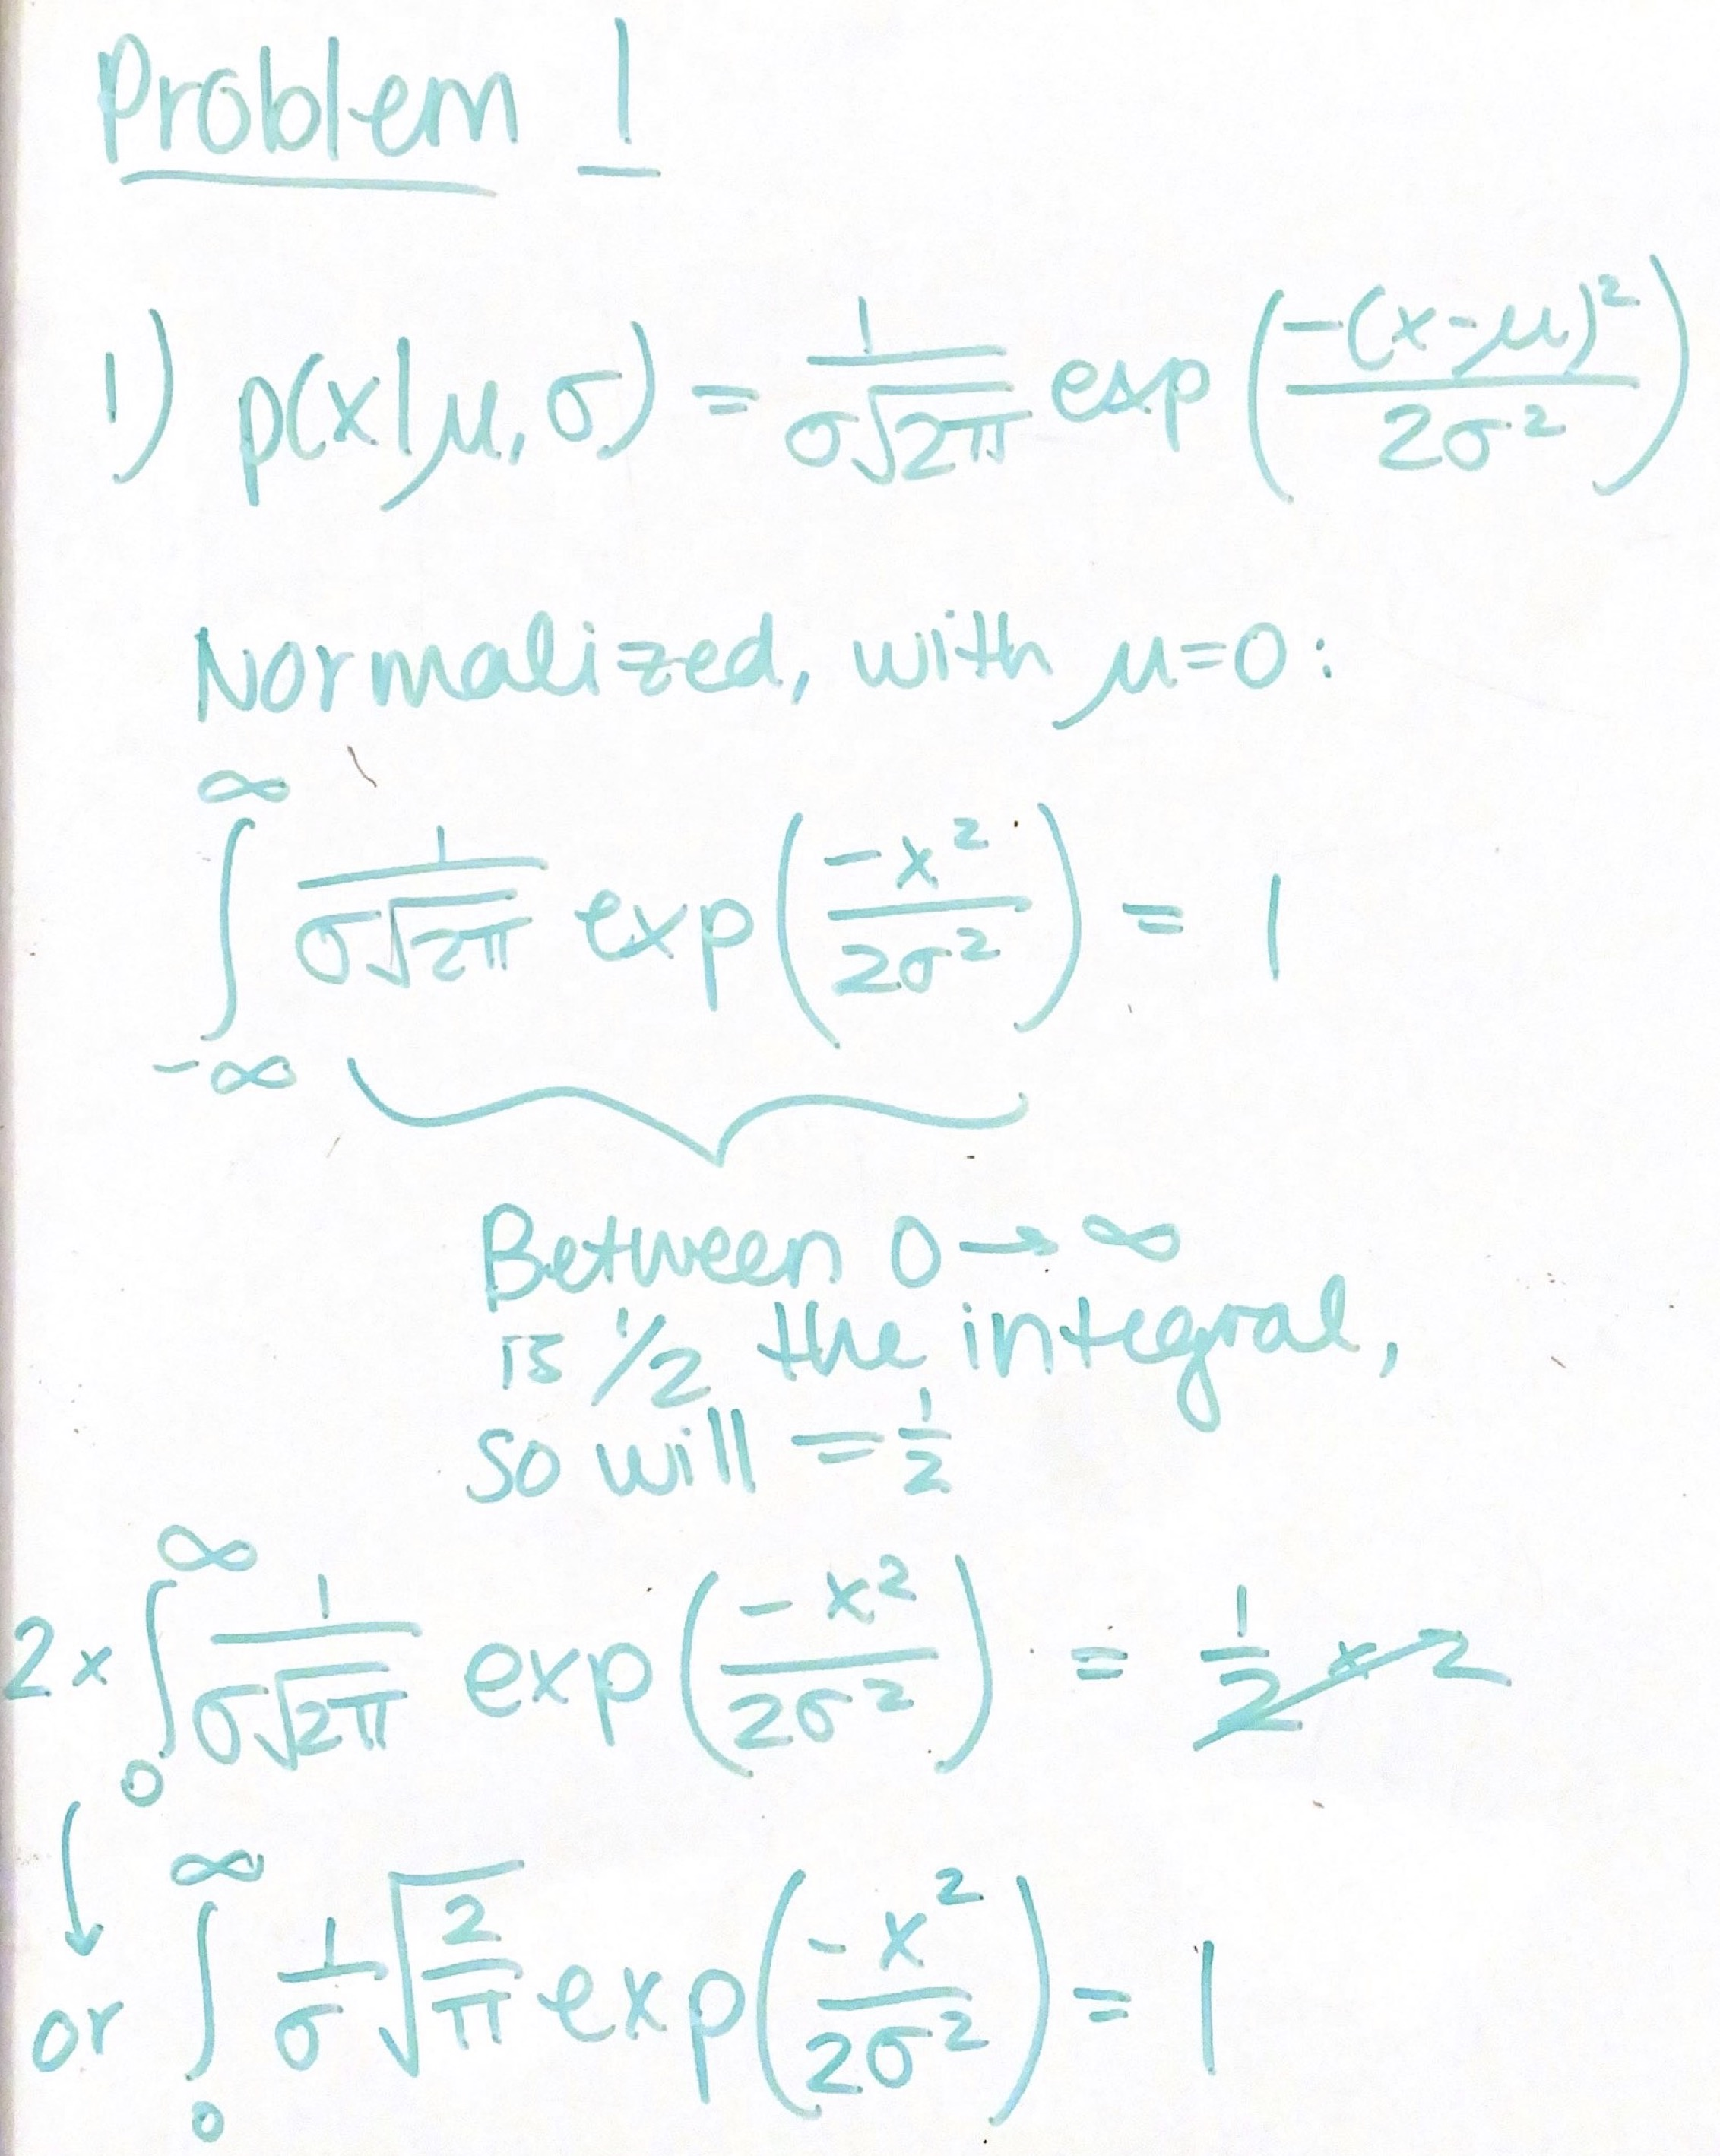

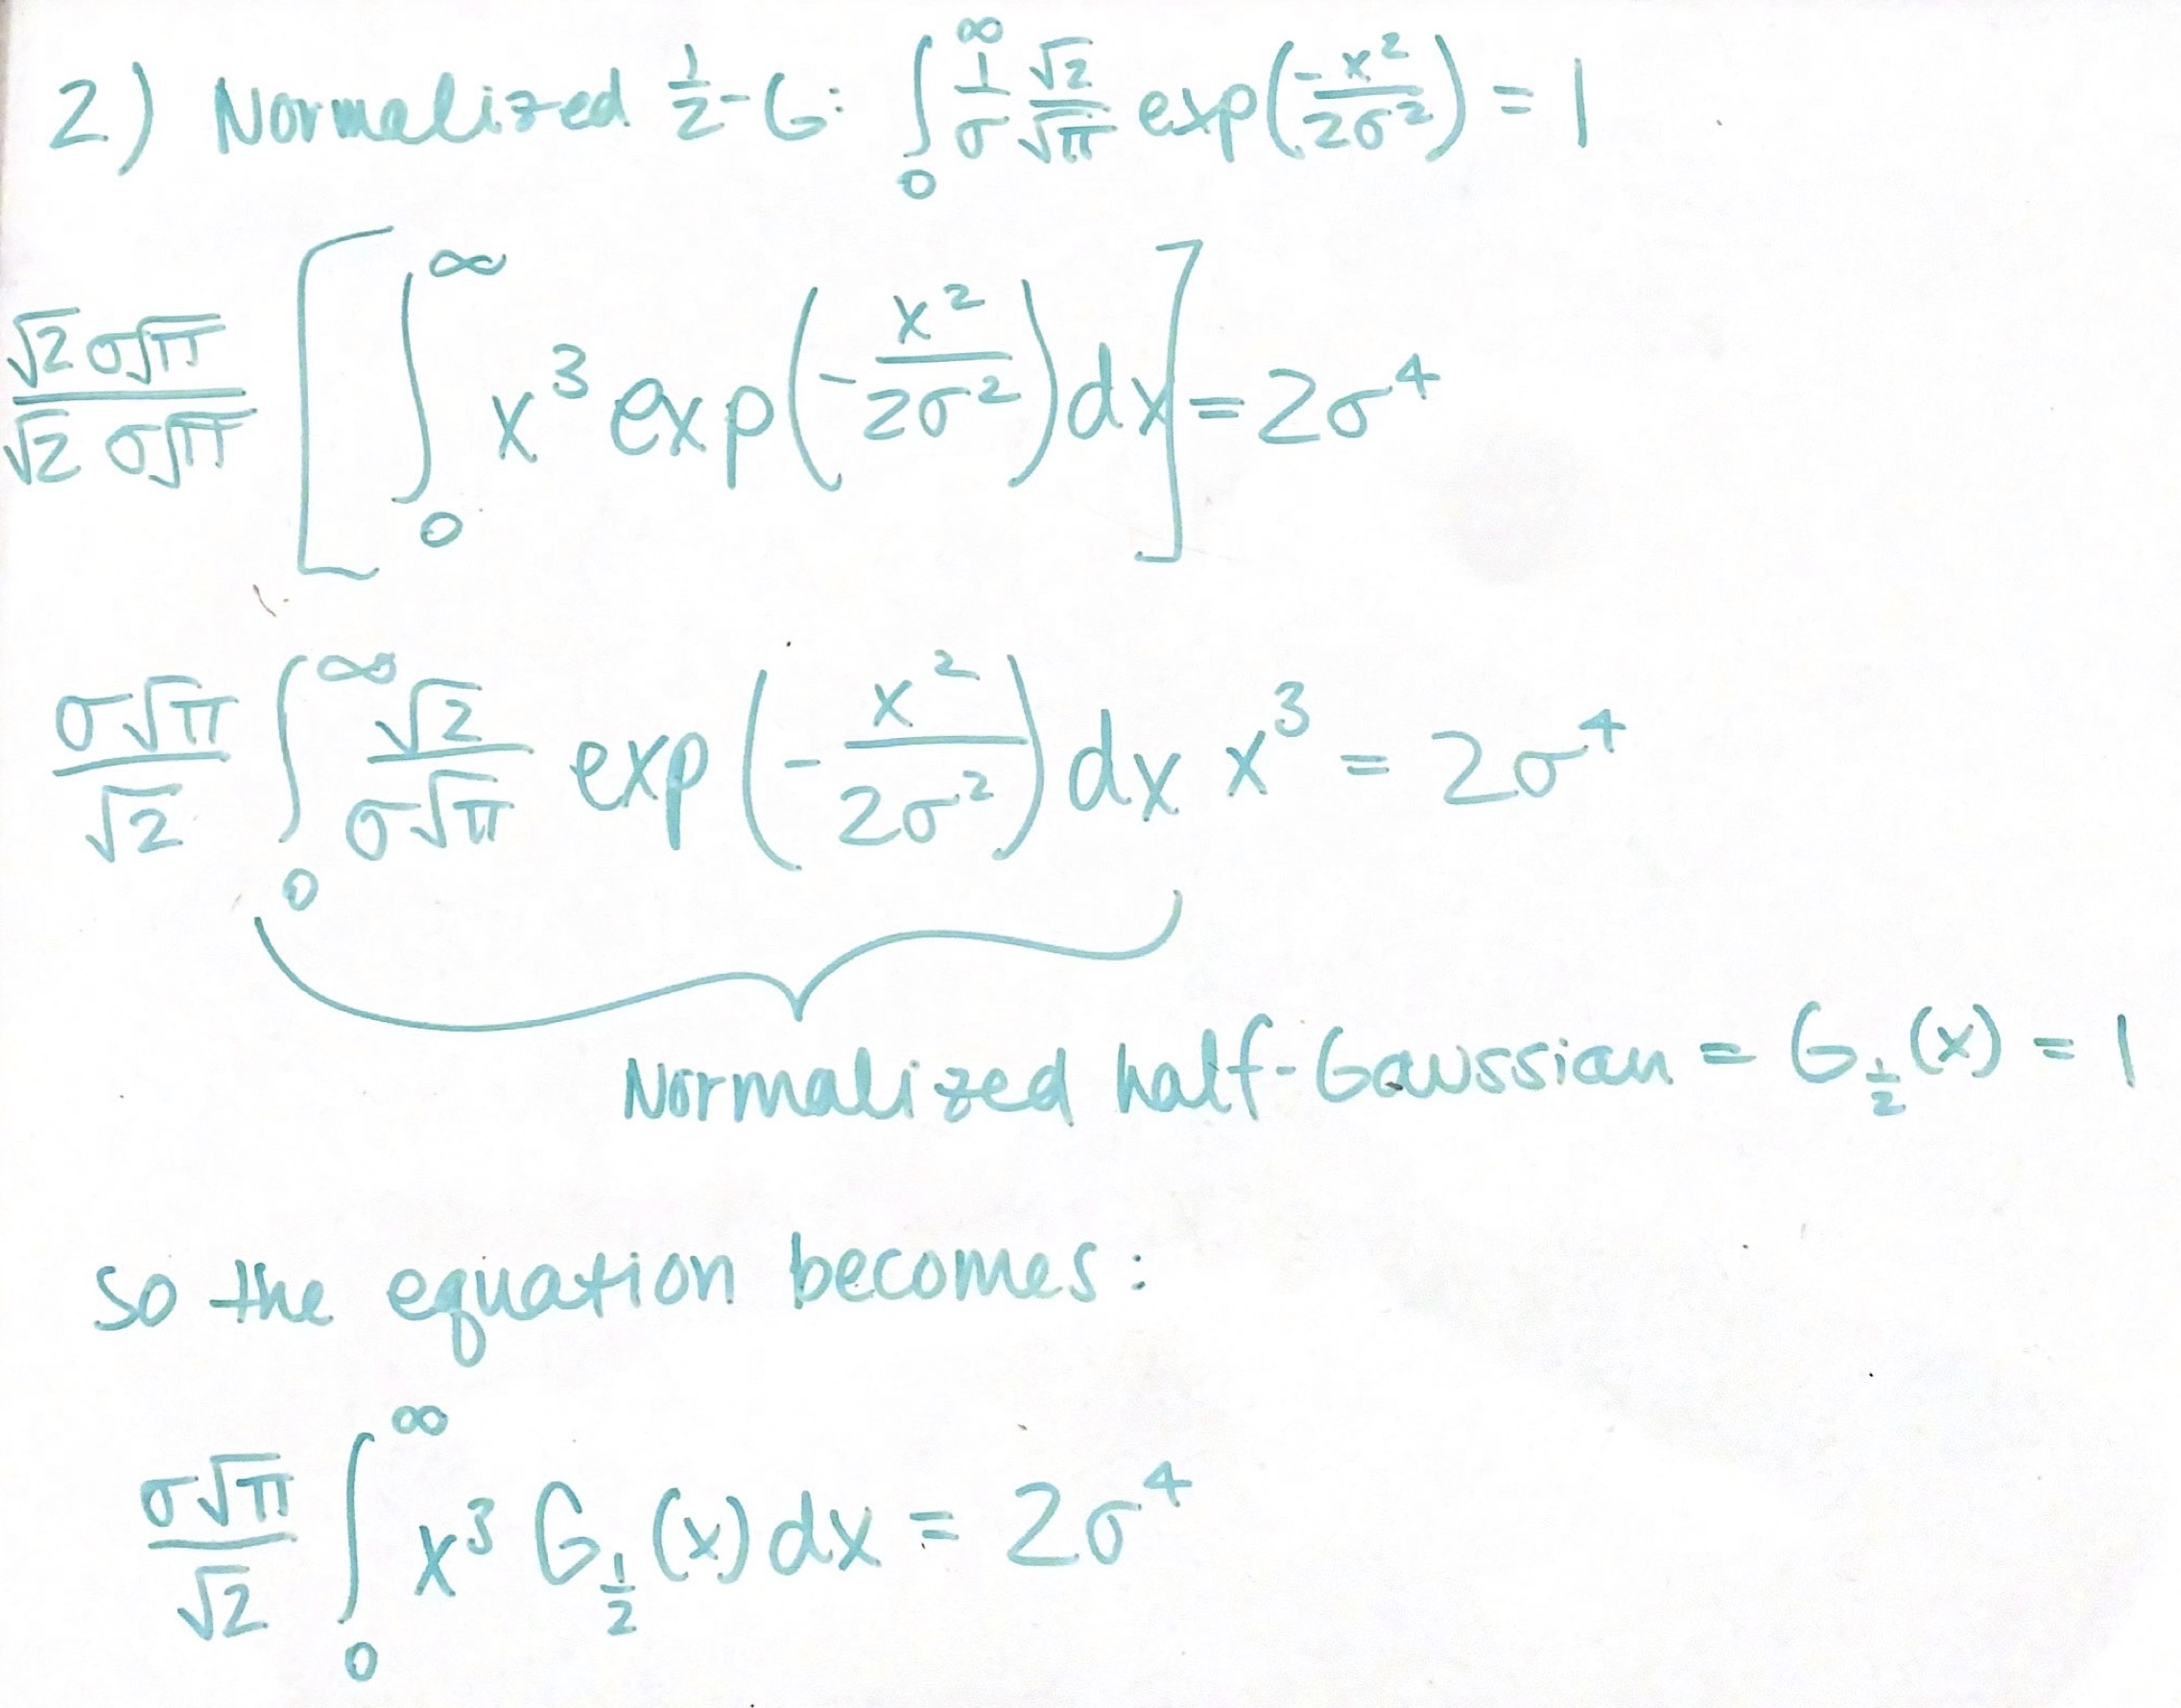

SRT: Excellent, Polina.

In [80]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
import scipy.stats
from scipy.stats import norm
from scipy.stats import poisson

In [117]:
N = 100000
sigma = 3
distN = norm(0,sigma) #creating normal distribution
samples = distN.rvs(N)
mask = samples > 0
pos_samples = samples[mask] #only positive values from distribution

#integration over half-gaussian normalized to be = 1
#so only normalization factors and x^3 needed in integration
MC_integ = np.sum(sigma*np.sqrt(np.pi/2)*(pos_samples**3))/len(pos_samples)
print('Value from MC integration:',MC_integ)

RHS = 2*sigma**4
print('Value from RHS of equation:',RHS)

Value from MC integration: 160.27901661698087
Value from RHS of equation: 162


SRT: Great!

In [134]:
Ns = [100,1000,10000]

data = []
for N in Ns:
    N_array = []
    for i in range(100):
        sample = distN.rvs(N)
        mask = sample > 0
        sample = sample[mask]
        integ = np.sum(sigma*np.sqrt(np.pi/2)*(sample**3))/len(sample)
        N_array.append(integ)
    data.append(N_array)

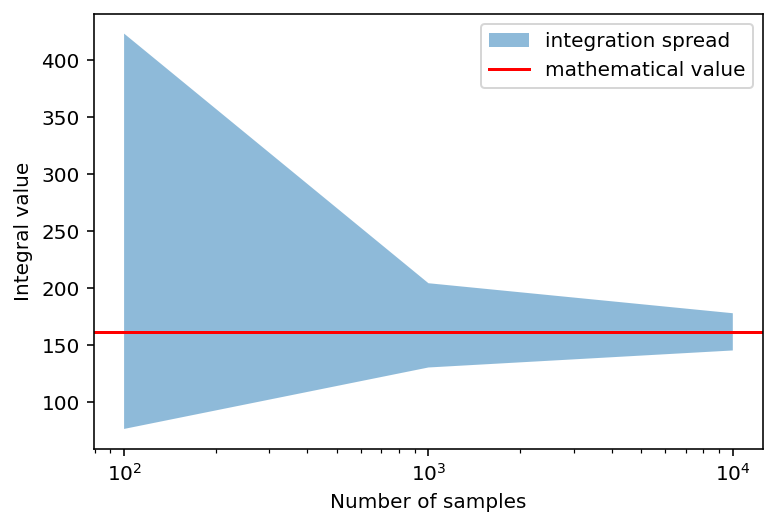

In [146]:
ymins = [min(N_val) for N_val in data]
ymaxs = [max(N_val) for N_val in data]

plt.fill_between(Ns,ymins,ymaxs,label='integration spread',alpha=0.5)
plt.axhline(2*sigma**4,color='r',label='mathematical value')
plt.xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Integral value')
plt.legend()
plt.show()

SRT: Very good! Minor point that the plot should also include the 10^5 sample case as well. -1

## Problem 2

This question is about IQ. It's a flawed and questionable metric, but useful for this problem. By definition, IQ is calibrated as a Gaussian distribution with $\mu=100$ and $\sigma=15$. 

1) Create a `scipy.stats` Gaussian object with these properties. Plot the distribution, and print out 10 random draws, along with the pdf at $x=145$. 

2) Access the `cdf` property of the Gaussian object and plot it over the same $x$-range as in (1) but in a different figure. Access the `ppf` property (percent point function) and use *inverse transform sampling* of the cdf to draw $10^4$ random samples, and make a histogram of these. Overplot the pdf from (1). These should match.

3) What fraction of people have IQ > 145? *Hint: investigate all the properties of the Gaussian object from (1) to find the relevant property that gives you this, or perform a calculation involving the cdf.*

4) What IQ corresponds to "one in a million"?

### Solution

10 random draws: [ 52.94011758  93.47983911  97.80102428 101.2905966  104.28038307
  69.77510723 104.47287815  99.55312496  91.02292498 100.37532724]
pdf at x=145: 0.0002954565607958672


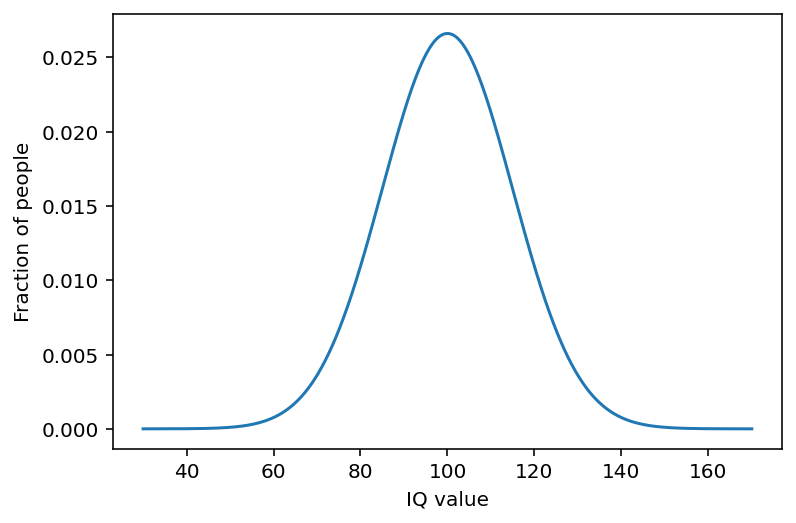

In [66]:
IQdist = norm(100,15) #Gaussian distribution for IQ
draws = IQdist.rvs(10) #10 random draws
print('10 random draws:',draws)
x = np.linspace(30,170,1000)
p = IQdist.pdf(x=145) # pdf evaluated at x=145
print('pdf at x=145:',p)

#plotting PDF
plt.plot(x,IQdist.pdf(x))
plt.xlabel('IQ value')
plt.ylabel('Fraction of people')
plt.show()

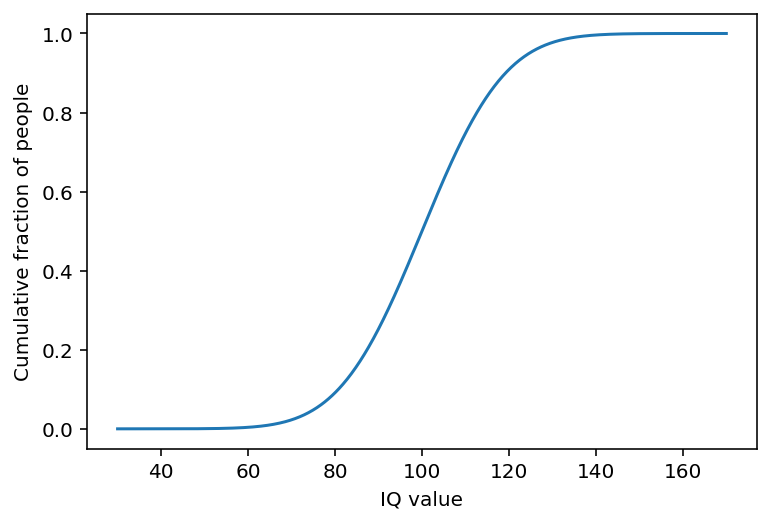

In [67]:
#plotting CDF
plt.plot(x,IQdist.cdf(x))
plt.xlabel('IQ value')
plt.ylabel('Cumulative fraction of people')
plt.show()

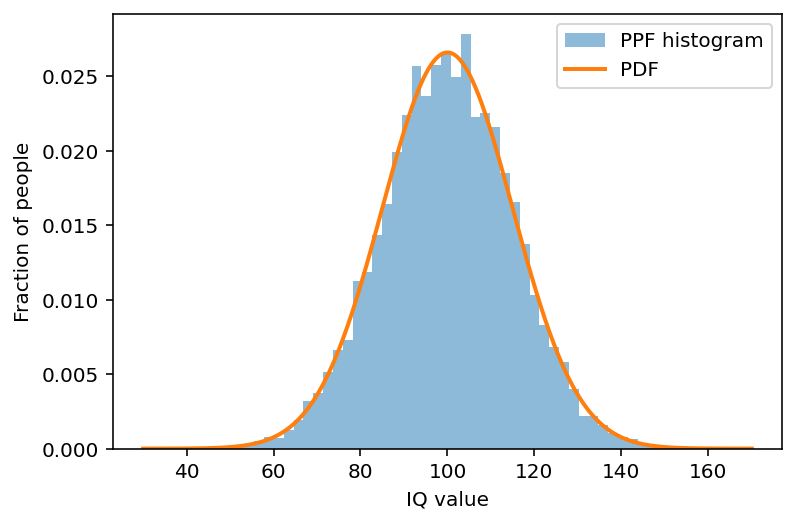

In [78]:
N = 10000
x_ppf = np.random.uniform(0,1,N) #need values between 0-1 since PPF is inverse of CDF, which goes from 0-->1

#plotting PPF histogram with PDF overplot
plt.hist(IQdist.ppf(x_ppf), bins=50, alpha=0.5, density=True, label='PPF histogram')
plt.plot(x,IQdist.pdf(x), lw=2, label='PDF')
plt.xlabel('IQ value')
plt.ylabel('Fraction of people')
plt.legend(loc='upper right')
plt.show()

SRT: Awesome.

In [110]:
#can use "survival function" for fraction of people with IQ > 145, which returns 1 - cdf(145)
print('Fraction of those with IQ > 145:', IQdist.sf(145))

#one in a million = 1/1000000 or 1e-6
#so for IQ corresponding to IQdist.sf(1e-6) can use inverse survival function
print('One in a million IQ:',IQdist.isf(1e-6))

#there SHOULD be another "one in a million" IQ on the other end too

Fraction of those with IQ > 145: 0.0013498980316300933
One in a million IQ: 171.30136463234348


## Problem 3

This question is about Poisson distributions. A famous early application was an analysis of Prussian cavalryman horse-kick deaths by [Bortkiewicz](https://www.wikiwand.com/en/Ladislaus_Bortkiewicz) in 1898. Let's take a short look at the kind of data he analyzed.

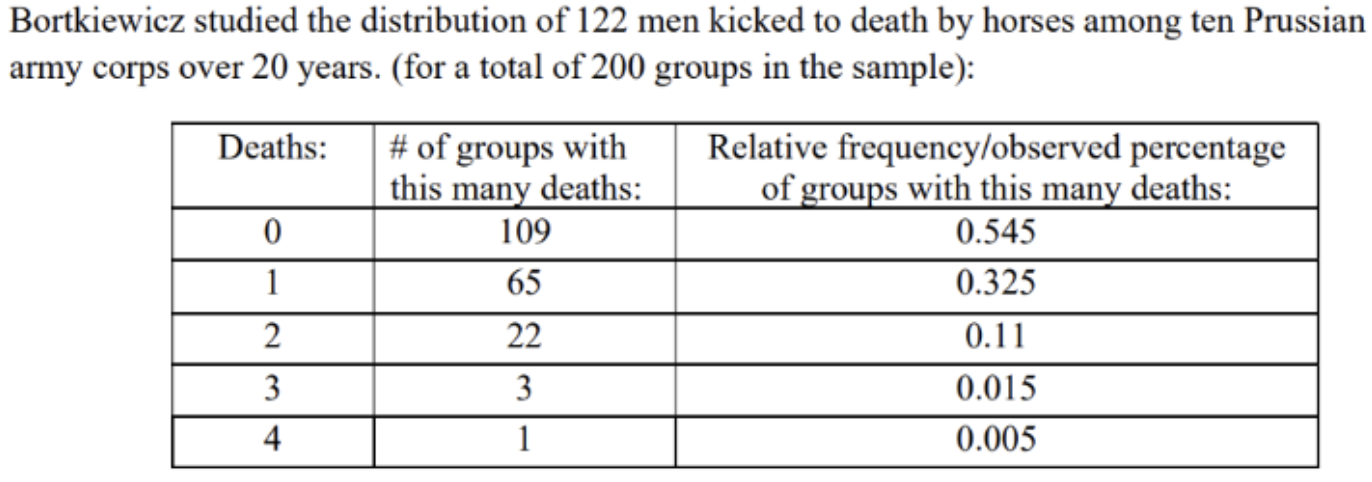

The data essentially consist of 200 total years of Prussian army corps information (i.e. ten army corps over 20 years).

1) Make a plot of the first and third columns of this data.

2) Plot a few Poisson distributions on top that are characterized by different $\mu$ values that might be reasonable guesses for how the data is distributed.

3) We'll come to model fitting next week, but for now use the descriptive sample statistics that you can calculate from this data to deduce the $\mu$ of the modeled Poisson distribution, e.g. the mean, std, median, mode, skewness, and kurtosis, where relevant. Do this however you like, but note that with the data in the table you won't just be able to get a sample mean, since these are tabulated densities, not samples. 

*Hint: use a weighted mean, or alternatively make a dataset that has the numbers 0,1,2,3,4 in agreement with their frequency in the table.*

4) Plot the Poisson distribution with the $\mu$ found in (3) alongside the data.

### Solution

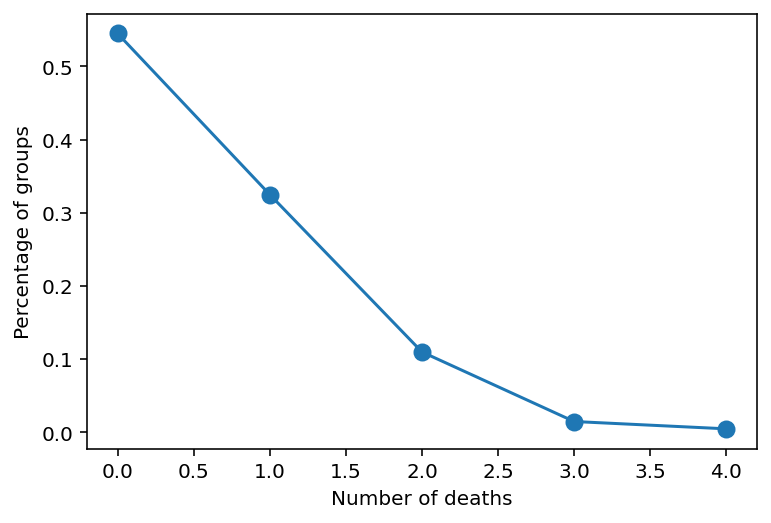

In [87]:
#plot of first and third columns

deaths = np.arange(5)
percents = np.array([0.545,0.325,0.11,0.015,0.005])

plt.plot(deaths,percents,marker='o',ms=8,ls='-')
plt.xlabel('Number of deaths')
plt.ylabel('Percentage of groups')
plt.show()

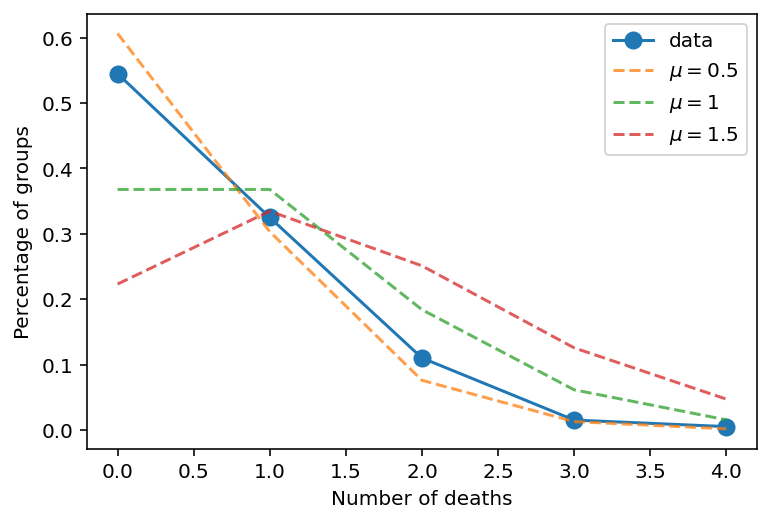

In [100]:
#overplotting possible poisson distributions

mu = [0.5,1,1.5]
psns = [poisson(m) for m in mu]

plt.plot(deaths,percents,marker='o',ms=8,ls='-',label='data')
for psn,val in zip(psns,mu):
    plt.plot(deaths,psn.pmf(deaths),ls='dashed',alpha=0.75,label=f'$\mu={val}$')
plt.xlabel('Number of deaths')
plt.ylabel('Percentage of groups')
plt.legend()
plt.show()

#looks close to 0.5, probably a bit higher

True mu: 0.6100000000000001


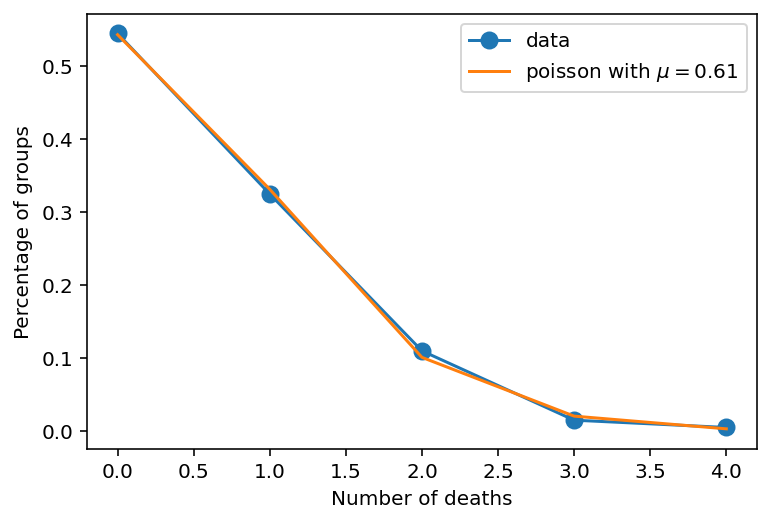

In [109]:
#finding true mu of distribution
#using a weighted mean:
true_mu = np.average(deaths, weights=percents)
print('True mu:',true_mu)
distP = poisson(true_mu)

plt.plot(deaths,percents,marker='o',ms=8,ls='-',label='data')
plt.plot(deaths,distP.pmf(deaths),label='poisson with $\mu=0.61$')
plt.xlabel('Number of deaths')
plt.ylabel('Percentage of groups')
plt.legend()
plt.show()

SRT: Excellent!